https://github.com/Zak-Basso/supMLfinal  
https://www.kaggle.com/datasets/ianktoo/simulated-roads-accident-data/  
https://www.kaggle.com/competitions/playground-series-s5e10/data  


In [22]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor, plot_importance
import seaborn as sns
import shap

train = pd.read_csv('data/train.csv').drop(columns=['id'])
train_small = train.iloc[:int(.1*len(train))]
X_train = train.drop(columns=['accident_risk'])
test = pd.read_csv('data/test.csv')
X_test = test.drop(columns=['id'])
categorical = {'road_type':None, 'lighting':None, 'weather':None, 'time_of_day':None}

for cat in categorical:
    encoder = LabelEncoder()
    X_train[cat] = encoder.fit_transform(X_train[cat])
    X_test[cat] = encoder.transform(X_test[cat])
    categorical[cat] = encoder
y_train = train['accident_risk']



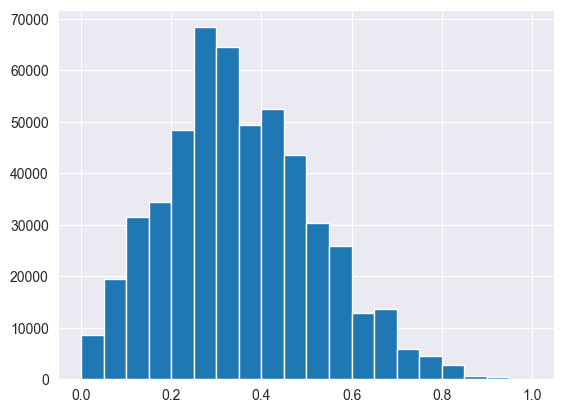

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   road_type               517754 non-null  int64  
 1   num_lanes               517754 non-null  int64  
 2   curvature               517754 non-null  float64
 3   speed_limit             517754 non-null  int64  
 4   lighting                517754 non-null  int64  
 5   weather                 517754 non-null  int64  
 6   road_signs_present      517754 non-null  bool   
 7   public_road             517754 non-null  bool   
 8   time_of_day             517754 non-null  int64  
 9   holiday                 517754 non-null  bool   
 10  school_season           517754 non-null  bool   
 11  num_reported_accidents  517754 non-null  int64  
dtypes: bool(4), float64(1), int64(7)
memory usage: 33.6 MB


<Axes: >

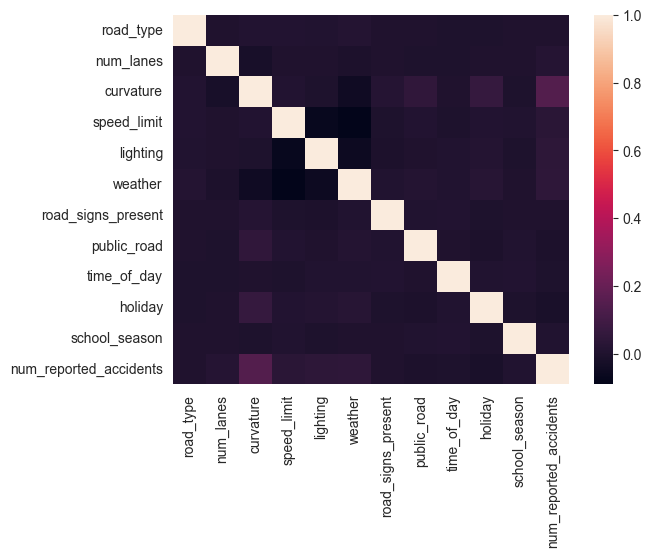

In [23]:
plt.hist(train['accident_risk'], bins=20)
plt.show()
X_train.info()
sns.heatmap(X_train.corr())

In [24]:
model = LinearRegression()
model.fit(X_train, y_train)
yp = model.predict(X_train)

acc = np.sqrt(mean_squared_error(y_train, yp))
print("rmse", acc)

rmse 0.08853810684755295


In [25]:
model = RandomForestRegressor(n_estimators=20)
model.fit(X_train, y_train)
yp = model.predict(X_train)

rmse = np.sqrt(mean_squared_error(y_train, yp))
print("rmse", rmse)


rmse 0.024919050510624756


In [26]:
model = GradientBoostingRegressor(n_estimators=100)
model.fit(X_train, y_train)
yp = model.predict(X_train)
rmse = np.sqrt(mean_squared_error(y_train, yp))
print("rmse", rmse)

rmse 0.05686381984159558


In [27]:
model = XGBRegressor(n_estimators= 400, max_depth=10, learning_rate= 0.05, colsample_bytree= 0.8)
model.fit(X_train, y_train)
yp = model.predict(X_train)
rmse = np.sqrt(mean_squared_error(y_train, yp))
print("rmse", rmse)

# param_grid = {
#     'n_estimators': [200, 400, 600],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'max_depth': [4, 6, 8],
#     'colsample_bytree': [0.7, 0.8, 1.0]
# }
# 
# search = RandomizedSearchCV(model, param_grid, cv=3, n_iter=15, scoring='neg_root_mean_squared_error', n_jobs=-1)
# search.fit(X_train, y_train)
# print(search.best_params_)

#n_estimators= 200, max_depth=8, learning_rate= 0.05, colsample_bytree= 0.8

rmse 0.05270957911178872


In [28]:
test['accident_risk'] = model.predict(X_test)
test[['id','accident_risk']].to_csv('test_pred.csv', index=False)
print("done")

done


| Model / Params                                                              | Train | Test  |
|-----------------------------------------------------------------------------|:-----:|:-----:|
| LinearRegression                                                            | .0885 | .0882 |
| RandomForestRegressor<br/>n_estimators=20                                   | .0249 | .0604 |
| RandomForestRegressor<br/>n_estimators=100                                  | .0231 | .0591 |
| GradientBoostingRegressor<br/>n_estimators=20                               | .0721 |       |
| GradientBoostingRegressor<br/>n_estimators=100                              | .0569 | .0565 |
| XGBRegressor<br/>                                                           | .0555 | .0557 |
| XGBR   n_est=200, max_depth=8, <br/>learning_rate=.05, comsample_bytree=.8  | .0553 | .0556 |
| XGBR   n_est=200, max_depth=10, <br/>learning_rate=.05, comsample_bytree=.8 | .0538 | .0557 |
| XGBR   n_est=200, max_depth=14, <br/>learning_rate=.05, comsample_bytree=.8 | .0437 | .0573 |



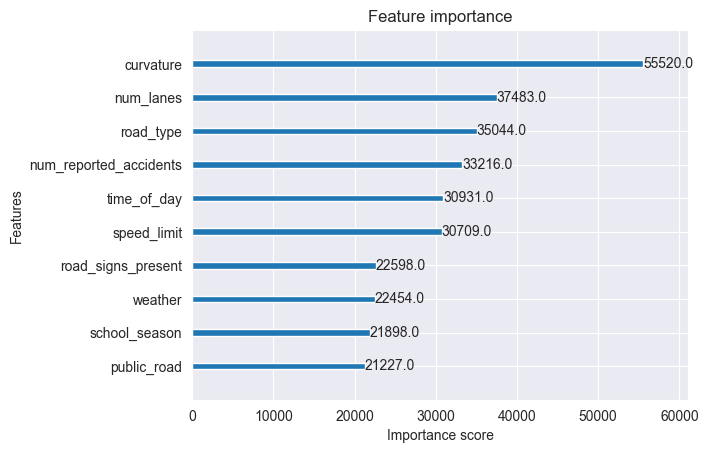

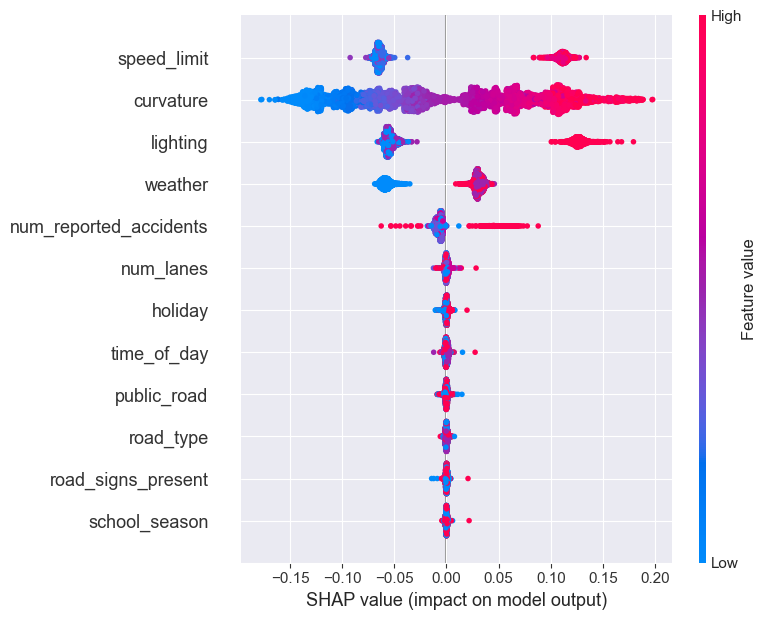

In [29]:
plot_importance(model, max_num_features=10)
plt.show()

sample_idx = np.random.choice(len(X_test), 5000, replace=False)
X_sample = X_test.iloc[sample_idx]

explainer = shap.Explainer(model)
shap_values = explainer(X_sample)
shap.summary_plot(shap_values, X_sample)

#### Problem -  
The goal provided by the kaggle dataset is to predict the likelihood of accidents on different types of roads. The dataset includes 12 informative features such as road type, num lanes, curvature, lighting, and speed limit.

Because our target "accident_risk" is continuous this is a regression problem evaluated with rmse via Kaggle's hidden test data.

#### EDA -  
Our target distribution is concentrated around the .3 mark with a tail extending towards higher risk. Therefore, most driving situations entail low risk while some distinct high risk situations and locations exist.  

I encoded the categorical features: road_type, lighting, weather, time_of_day with LabelEncoder for use in my models.  

The heatmap reveals extremely low correlation between the features, I believe because this was a fully simulation generated dataset. Because its generated almost all the features have nearly perfect distribution in the set.  

According to XGBoost's feature importance, aswell as an SHAP explainer ran on a small subset of data top features include: curvature, num_reported_accidents, num_lanes, and time_of_day.  

#### Analysis -  

See above table for all results.
| Model / Params                                                              | Train | Test  |
|-----------------------------------------------------------------------------|:-----:|:-----:|
| LinearRegression                                                            | .0885 | .0882 |
| RandomForestRegressor<br/>n_estimators=100                                  | .0231 | .0591 |
| GradientBoostingRegressor<br/>n_estimators=100                              | .0569 | .0565 |
| XGBR   n_est=200, max_depth=8, <br/>learning_rate=.05, comsample_bytree=.8  | .0553 | .0556 |

I trained multiple models starting with LinearRegression which had poor but consistent performance on the train and test sets.  
Random Forests and Gradient Boosting captured what the linear model couldn't, and achieve lower rmse on both sets, but ran slowly.  
XGBoost achieved speedier result with lower rmse and after testing params achieved a rmse .00022 off of the top score, increasing the depth achieved lower train scores but pushed too far into overfitting.  

#### Discussion/Conclusion -  
The tree based ensemble methods: Random Forest, Gradient Boost, XG Boost outperformed linear models. While XGBoost gave the best balance of train + test rmse.  

A model predicting high accident risk areas, conditions, and times could help inform either a general population of drivers or, if a specifically high risk situation exists, targeted messaging could be applied to drivers.  
Additionally predictive modelling could be done on proposed roads before construction with a simulated set of conditions to allow preventive changes to be taken before construction.  
Some features that I think could improve the model would be more specific road condition categories such as provided by CDOT, or streetlight lit areas when night driving is considered. Live or historic traffic data could be added if the model was to be used in a live driving or preventive way.


1